# Задание 1

## Описание задачи

Вам дана таблица заявок на кредит: id - номер заявки, created_date - время создания заявки, decision - решение по заявке, decision_date - время принятия решения, issued_sum - сумма выдачи, issued_date - время выдачи

Задача: Менеджмент хочет понимать, находятся ли бизнес-показатели в норме в течение дня (например на 14:00, 18:00 и т. д.) в сравнении с показателями за предыдущие дни. Показатели: кол-во заявок, уровень одобрения, очередь заявок без решения, уровень выдач, средняя выданная сумма. Нормой можно считать показатели за последние 20 дней.

Предложите визуализации (концептуально или на примере) для ответа на такой вопрос бизнеса и напишите sql (любой диалект), который подготовит данные для этой визуализации.


## SQL

С точки зрения бизнеса вряд ли имеет смысл строить общий запрос для того чтобы вывести все данные, поэтому построим множество запросов

### Запрос для вывода количества заявок для каждого часа за последние 20 дней

SELECT 
    EXTRACT(HOUR FROM created_date) AS request_hour,
    COUNT(*) AS total_requests
FROM data
WHERE created_date >= NOW() - INTERVAL '20 days'
GROUP BY request_hour
ORDER BY request_hour;

### Запрос с уровнем одобрения для каждого часа за последние 20 дней

In [ ]:
SELECT 
    EXTRACT(HOUR FROM created_date) AS request_hour,
    COUNT(*) AS total_requests,
    COUNT(CASE WHEN decision = 'approved' THEN 1 END) AS approved_requests,
    ROUND(
        COUNT(CASE WHEN decision = 'approved' THEN 1 END) * 100.0 / NULLIF(COUNT(*), 0), 
        2
    ) AS approval_rate
FROM data
WHERE created_date >= NOW() - INTERVAL '20 days'
GROUP BY request_hour
ORDER BY request_hour;

- total_requests: общее количество заявок за каждый час.
- approved_requests: количество одобренных заявок за каждый час.
- approval_rate: уровень одобрения, рассчитанный как процент одобренных заявок от общего числа заявок за этот час.

### Таблица с очередью заявок без решения для каждого часа за последние 20 дней

In [ ]:
SELECT 
    EXTRACT(HOUR FROM created_date) AS request_hour,
    COUNT(*) AS pending_requests
FROM data
WHERE created_date >= NOW() - INTERVAL '20 days'
  AND decision = NULL
GROUP BY request_hour
ORDER BY request_hour;

- request_hour: час, в который были созданы заявки.
- pending_requests: количество заявок без решения за каждый час.

### Таблица с уровнем выдач для каждого часа за последние 20 дней

In [ ]:
SELECT 
    EXTRACT(HOUR FROM created_date) AS request_hour,
    COUNT(*) AS issued_requests
FROM data
WHERE created_date >= NOW() - INTERVAL '20 days'
  AND decision = 'approved' 
GROUP BY request_hour
ORDER BY request_hour;

- request_hour: час, в который были выданы заявки.
- issued_requests: количество выданных заявок за каждый час.

### таблица со среднем выданной суммой для каждого часа за последние 20 дней

In [ ]:
SELECT 
    EXTRACT(HOUR FROM created_date) AS request_hour,
    AVG(issued_amount) AS average_approved_amount
FROM data
WHERE created_date >= NOW() - INTERVAL '20 days'
  AND decision = 'approved' 
GROUP BY request_hour
ORDER BY request_hour;

- request_hour: час, в который были выданы заявки.
- average_approved_amount: средняя сумма выданных заявок за каждый час.

### Визуализация

1. График количества заявок:
  - Линейный график, показывающий количество заявок, поступивших в течение дня, с наложением средних значений за последние 20 дней.  
    
     
2. Уровень одобрения: 
  - Столбчатая диаграмма, показывающая процент одобренных заявок по часу с наложением среднего уровня одобрения за последние 20 дней.   
   
   
3. Очередь заявок без решения:
 - Гистограмма, показывающая количество заявок без решения в разные временные промежутки.     
 
 
 4. Уровень выдач и средняя выданная сумма:
   - Комбинированный график, где одна ось показывает количество выданных кредитов, а другая — среднюю сумму выдачи по времени.

# Задание 2

## Описание задачи

В архиве во вложении данные по выдачам кредитов и платежам: плановым и фактическим. Данные актуальны на 08.12.2022. Проанализируйте характер поведения клиентов с точки зрения просрочки: какая динамика просрочки, наблюдается ли рост или снижение?

Несостыковки в данных можно трактовать на свое усмотрение и отразить в отчете.




### Описание данных

* order_id – номер заявки
* created_at - дата создания заявки
* put_at - дата выдачи
* closed_at - дата закрытия
* issued_sum - сумма выдачи
* plan_at - дата планового платежа
* plan_sum_total - сумма планового платежа (накопленным итогом)
* paid_at - дата фактического платежа
* paid_sum - сумма фактического платежа

## Загрузка библиотек и данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np

Загрузим данные и посмотрим на датафреймы

In [10]:
data_orders = pd.read_csv(r'C:\Users\shurf\Desktop\Черновики\task_2_data\orders.csv', 
                          parse_dates=['created_at', 'put_at', 'closed_at']) 
data_orders = data_orders.sort_values('created_at')

In [11]:
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55748 entries, 0 to 55747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_id    55748 non-null  int64         
 1   created_at  55748 non-null  datetime64[ns]
 2   put_at      55748 non-null  datetime64[ns]
 3   closed_at   46472 non-null  datetime64[ns]
 4   issued_sum  55748 non-null  float64       
dtypes: datetime64[ns](3), float64(1), int64(1)
memory usage: 2.6 MB


In [12]:
data_payments = pd.read_csv(r'C:\Users\shurf\Desktop\Черновики\task_2_data\payments.csv', parse_dates=['paid_at'])
data_payments = data_payments.sort_values('paid_at')
data_payments['date'] = data_payments['paid_at'].dt.date

In [13]:
data_payments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143284 entries, 0 to 143283
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   order_id  143284 non-null  int64         
 1   paid_at   143284 non-null  datetime64[ns]
 2   paid_sum  143284 non-null  float64       
 3   date      143284 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.5+ MB


In [14]:
data_plan = pd.read_csv(r'C:\Users\shurf\Desktop\Черновики\task_2_data\plan.csv', parse_dates=['plan_at']) 
data_plan = data_plan.sort_values('plan_at')
data_plan['date'] = data_plan['plan_at'].dt.date

In [15]:
data_plan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420282 entries, 0 to 308535
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   order_id        420282 non-null  int64         
 1   plan_at         420282 non-null  datetime64[ns]
 2   plan_sum_total  420282 non-null  float64       
 3   date            420282 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 16.0+ MB


В таблице orders есть пропуски в столбце closed_at, что означает скорее всего то, что время закрытия еще не пришло, поэтому скорее всего нет смысла обрабатывать эти значения, так как они нам не помешают проанализировать тенденцию динамики просрочки

## Анализ

In [16]:
# Посмотрим на одного клиента из двух датафреймов, чтобы проверить согласованность данных
data_plan.query('order_id == 400001732')

,order_id,plan_at,plan_sum_total,date
0,400001732,2022-06-02,5600.0,2022-06-02
1,400001732,2022-07-02,9450.0,2022-07-02
2,400001732,2022-08-01,12170.0,2022-08-01
3,400001732,2022-08-31,14890.0,2022-08-31
4,400001732,2022-09-30,17610.0,2022-09-30
5,400001732,2022-10-30,20330.0,2022-10-30
6,400001732,2022-11-29,23050.0,2022-11-29


In [17]:
data_payments.query('order_id == 400001732')

,order_id,paid_at,paid_sum,date
153,400001732,2022-06-02 20:20:16.790,5600.0,2022-06-02
5859,400001732,2022-06-16 16:05:26.007,3850.0,2022-06-16
30992,400001732,2022-07-15 12:32:34.087,2720.0,2022-07-15
70290,400001732,2022-08-16 12:38:01.237,2720.0,2022-08-16
106905,400001732,2022-09-15 12:14:48.867,2720.0,2022-09-15
116452,400001732,2022-09-27 16:04:50.630,2720.0,2022-09-27
127082,400001732,2022-10-17 11:52:22.190,2720.0,2022-10-17


Видно что в случае планового платежа сумма считается куммулятивно

создадим датафрейм со всеми датами в течении полугода изучаемых данных и всеми уникальными order_id чтобы затем можно было посчитать наличие и сумму просрочки для каждого отдельного id на каждый момент времени.

В данном случае округлим все значения времени, чтобы работать только с датой, думаю масштабировать сильнее не нужно для того чтобы обозначить тенденцию

### Создание декартого пространства

In [18]:
data_time = pd.date_range(data_plan['plan_at'].min(), data_payments['paid_at'].max())
data_time = pd.DataFrame(data_time)
data_time.columns = ['date']
data_time['date'] = data_time['date'].dt.date
data_time

,date
0,2022-06-02
1,2022-06-03
2,2022-06-04
3,2022-06-05
4,2022-06-06
...,...
185,2022-12-04
186,2022-12-05
187,2022-12-06
188,2022-12-07


In [19]:
dates = data_time['date'].unique()
ids  = data_payments['order_id'].unique()

In [20]:
combinations = pd.MultiIndex.from_product([dates, ids], names=['date', 'order_id'])

In [21]:
## Создание общего датафрейма для анализа просрочек
df = pd.DataFrame([x[0] for x in combinations], [x[1] for x in combinations]).reset_index()
df.columns=['order_id', 'date']
df


,order_id,date
0,400013633,2022-06-02
1,400018480,2022-06-02
2,400032001,2022-06-02
3,400033195,2022-06-02
4,400039407,2022-06-02
...,...,...
10208695,451464974,2022-12-08
10208696,480639870,2022-12-08
10208697,436737877,2022-12-08
10208698,487895263,2022-12-08


Теперь нам необходимо присоеденить к этой таблице фактические и запланированные платежи

In [22]:
# Так как сумма запланированного платежа считается куммулятивно, то сумму фактического платежа тоже расчитаем куммулятивно
data_payments['paid_cum_sum'] = data_payments.groupby('order_id')['paid_sum'].cumsum()

In [23]:
data_payments

,order_id,paid_at,paid_sum,date,paid_cum_sum
0,400013633,2022-06-02 00:48:13.800,2500.00,2022-06-02,2500.00
1,400018480,2022-06-02 01:52:05.707,1070.00,2022-06-02,1070.00
2,400032001,2022-06-02 04:55:40.307,4200.00,2022-06-02,4200.00
3,400033195,2022-06-02 05:44:23.480,2850.00,2022-06-02,2850.00
4,400039407,2022-06-02 06:53:54.503,10100.00,2022-06-02,10100.00
...,...,...,...,...,...
143279,469255350,2022-12-08 12:57:23.747,343.99,2022-12-08,2566.90
143280,452985418,2022-12-08 12:59:40.997,984.83,2022-12-08,14380.24
143281,490824962,2022-12-08 13:09:21.673,866.04,2022-12-08,10617.81
143282,480026135,2022-12-08 13:25:11.987,1193.25,2022-12-08,15415.50


In [24]:
df = df.merge(data_payments[['order_id', 'date', 'paid_cum_sum']], on=['order_id','date'], how='left')
df

,order_id,date,paid_cum_sum
0,400013633,2022-06-02,2500.00
1,400018480,2022-06-02,1070.00
2,400032001,2022-06-02,4200.00
3,400033195,2022-06-02,2850.00
4,400039407,2022-06-02,10100.00
...,...,...,...
10217291,451464974,2022-12-08,NaN
10217292,480639870,2022-12-08,NaN
10217293,436737877,2022-12-08,23583.12
10217294,487895263,2022-12-08,49469.37


Теперь добавим сюда плановый платеж таким же способом

In [26]:
df = df.merge(data_plan[['order_id', 'date', 'plan_sum_total']], on=['order_id','date'], how='left')
df

,order_id,date,paid_cum_sum,plan_sum_total
0,400013633,2022-06-02,2500.00,2500.00
1,400018480,2022-06-02,1070.00,1070.00
2,400032001,2022-06-02,4200.00,4200.00
3,400033195,2022-06-02,2850.00,2850.00
4,400039407,2022-06-02,10100.00,NaN
...,...,...,...,...
10217291,451464974,2022-12-08,NaN,NaN
10217292,480639870,2022-12-08,NaN,NaN
10217293,436737877,2022-12-08,23583.12,NaN
10217294,487895263,2022-12-08,49469.37,36482.99


In [27]:
#заполним пропуски для каждого ID методом ffill
df['paid_cum_sum'] = df.groupby('order_id')['paid_cum_sum'].ffill()
df['plan_sum_total'] = df.groupby('order_id')['plan_sum_total'].ffill()
df

,order_id,date,paid_cum_sum,plan_sum_total
0,400013633,2022-06-02,2500.00,2500.00
1,400018480,2022-06-02,1070.00,1070.00
2,400032001,2022-06-02,4200.00,4200.00
3,400033195,2022-06-02,2850.00,2850.00
4,400039407,2022-06-02,10100.00,NaN
...,...,...,...,...
10217291,451464974,2022-12-08,9923.65,8424.92
10217292,480639870,2022-12-08,23422.69,17380.69
10217293,436737877,2022-12-08,23583.12,20863.12
10217294,487895263,2022-12-08,49469.37,36482.99


In [28]:
print(df['paid_cum_sum'].isnull().sum())
df['plan_sum_total'].isnull().sum()

2974043


2888063

Если в таблице остались пустые это значит что либо клиент начал платить раньше чем наступил срок первый срок фактического платежа, либо наступил срок фактического платежа, а клиент еще ничего не заплатил. В обоих случаях можно заполнить наны нулями.

In [29]:
df = df.fillna(0)
df

,order_id,date,paid_cum_sum,plan_sum_total
0,400013633,2022-06-02,2500.00,2500.00
1,400018480,2022-06-02,1070.00,1070.00
2,400032001,2022-06-02,4200.00,4200.00
3,400033195,2022-06-02,2850.00,2850.00
4,400039407,2022-06-02,10100.00,0.00
...,...,...,...,...
10217291,451464974,2022-12-08,9923.65,8424.92
10217292,480639870,2022-12-08,23422.69,17380.69
10217293,436737877,2022-12-08,23583.12,20863.12
10217294,487895263,2022-12-08,49469.37,36482.99


Мы получили таблицу, в которой по каждому дню и каждому order_id есть информация о плановом и фактическом платеже.

In [36]:
#Теперь добавим 2 новых столбца - сумма просрочки-досрочки и просто сумма просрочки 
df['overdue_summ'] = df['plan_sum_total'] - df['paid_cum_sum']
df['overdue_summ_only'] = df['plan_sum_total'] - df['paid_cum_sum']
df.loc[df['overdue_summ_only'] < 0, 'overdue_summ_only'] = 0
df.sample(10)

,order_id,date,paid_cum_sum,plan_sum_total,overdue_summ,overdue_summ_only
6952879,426909436,2022-10-09,4240.00,4600.00,360.00,360.0
9052156,424277718,2022-11-17,10900.00,11500.00,600.00,600.0
8478558,473014045,2022-11-06,6045.37,3825.37,-2220.00,0.0
3802221,445597818,2022-08-11,0.00,0.00,0.00,0.0
6365444,426829469,2022-09-28,4314.60,2721.85,-1592.75,0.0
356464,470992943,2022-06-08,0.00,0.00,0.00,0.0
1174739,460723216,2022-06-23,0.00,0.00,0.00,0.0
3453164,430197978,2022-08-05,7080.00,7080.00,0.00,0.0
1348002,407589011,2022-06-27,6360.00,6900.00,540.00,540.0
2799984,413087631,2022-07-24,10100.00,11500.00,1400.00,1400.0


## Построение графиков

### Диманика суммы платежей

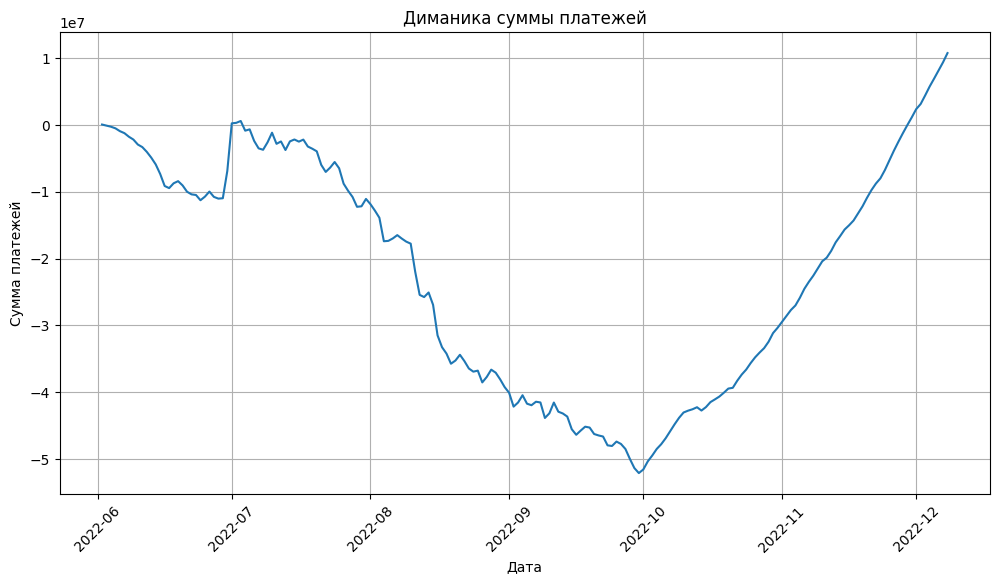

In [31]:
data_overdue = df.groupby('date')['overdue_summ'].sum()

plt.figure(figsize=(12, 6))
data_overdue.plot()
plt.title('Диманика суммы платежей')
plt.xlabel('Дата')
plt.ylabel('Сумма платежей')
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Диманика суммы просроченных платежей

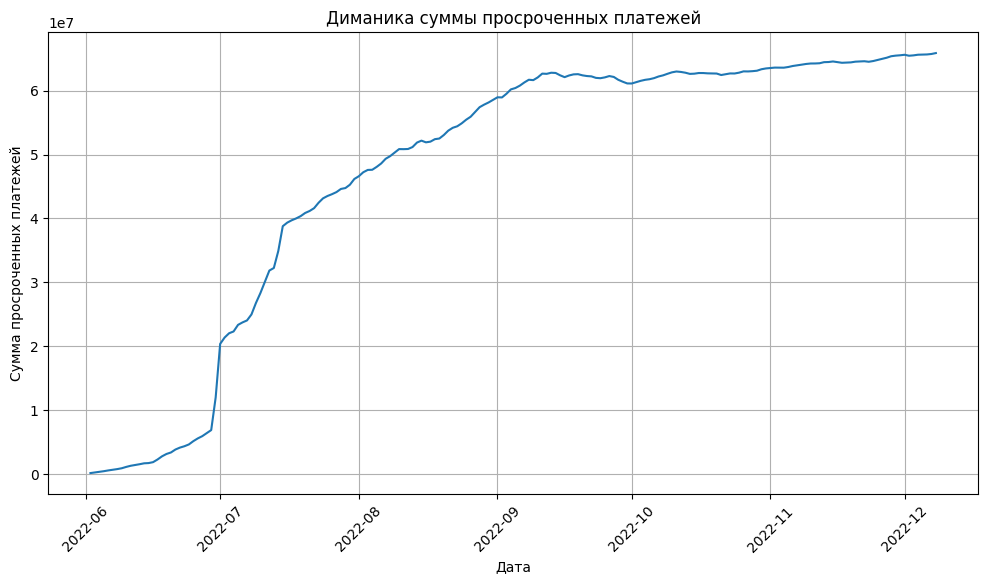

In [32]:
data_overdue_only = df.groupby('date')['overdue_summ_only'].sum()

plt.figure(figsize=(12, 6))
data_overdue_only.plot()
plt.title('Диманика суммы просроченных платежей')
plt.xlabel('Дата')
plt.ylabel('Сумма просроченных платежей')
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Динамика процента просроченных платежей

In [33]:
data_procent = df.groupby('date')[['overdue_summ_only', 'plan_sum_total']].sum()

In [34]:
data_procent['percent'] = (data_procent['overdue_summ_only'] / data_procent['plan_sum_total']) * 100
data_procent['percent']= data_procent['percent'].fillna(100)

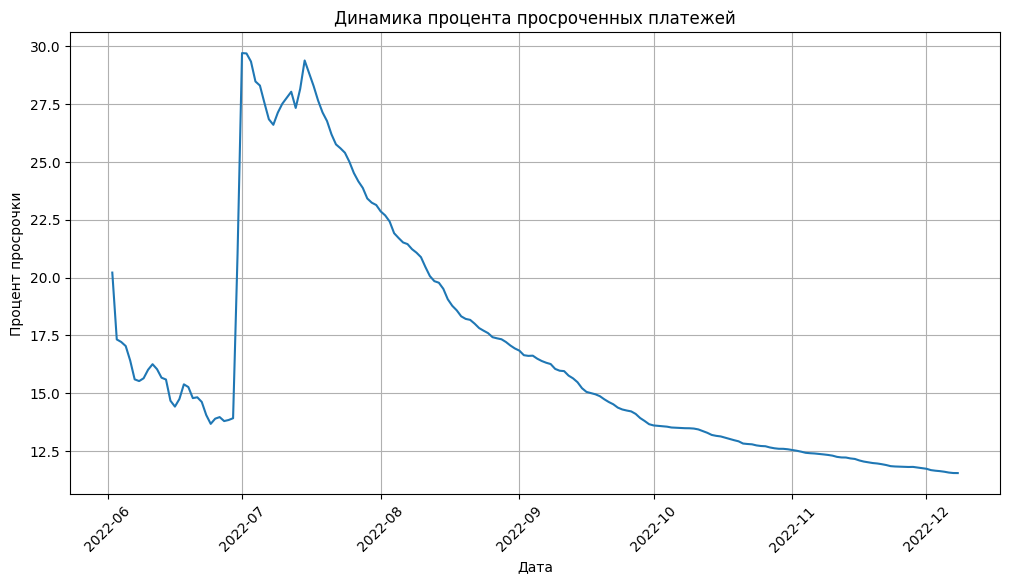

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(data_procent.index.values, data_procent['percent'].values)
plt.title('Динамика процента просроченных платежей')
plt.xlabel('Дата')
plt.ylabel('Процент просрочки')
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Вывод

Из графиков видно, что хоть и сумма просроченных платежей почти неубывающе растет, процент просроченных платеж от суммы запланированного платежа равномерно падает начиная с середины седьмого месяца 